<div style="text-align: right" align="right"><i>Peter Norvig, 2015–2025</i></div>

# The Traveling Salesperson Problem

The [***Traveling Salesperson Problem***](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (abbreviated **TSP**) is a classic computer science problem:

***Given a set of cities and the distances between them, what is the shortest tour that visits each city exactly once, and returns to the starting city?***

[![](http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/map002g.png)](http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html)

In this notebook we will develop several algorithms that solve the problem, and more generally show *how to think about* solving  problems. We'll discuss very general *strategies* that can be used to attack any algorithmic problem, and show how those strategies lead to solutions. Then we'll benchmark the algorithms we develop, comparing them for run time and for how close they come to the shortest possible tour. 


# Implementation of Basic Concepts

I'll identify the basic concepts and make implementation choices for them:

- **City**: A point in the 2D plane. I'll use [**complex numbers**](https://docs.python.org/3/c-api/complex.html), which are points in the (*real*, *imaginary*) plane. (An (*x*, *y*) tuple would also work.)
- **Cities**: A Python **set** of cities.
- **Tour**: An ordered list of cities. `[A, B, C]` is the tour consisting of links from `A` to `B` to`C` and back to `A`.
- **Link**: A two-city list reresenting a direct connection between the cities, e.g. `[A, B]`.
- **Segment**: A list representing a portion of a tour that does not loop back to the start.
  - For example, the **segment** `[A, B, C]` has two links, `[A, B]` and `[B, C], while the`**tour** `[A, B, C]` has a third,  `[C, A]`.
- **Distance**: A function `distance(A, B)` will compute the straight-line distance between two points.
- **Tour length**: A function `tour_length(tour)` will compute the length of a tour: the sum of the distances of the links.
- **Valid tour**: a tour that visits every city exactly once.
- **TSP algorithm**: Functions with the signature `tsp(cities: Cities) -> Tour`.

**Notes**: 
- Some authors use "cycle" or "circuit" or "[Hamiltonian path](https://en.wikipedia.org/wiki/Hamiltonian_path)" instead of "tour."
- I'm using the [**Euclidean distance**](http://en.wikipedia.org/wiki/Euclidean_distance) measure: the distance between two points is the length of a straight line between them. This measure is **symmetric** (the total distance from `A` to `B` is the same as the distance from `B` to `A`) and satisifes the **triangle inequality** (the distance from `A` to `B` to `C` can never be less than the distance from `A` to `C`). But not all distance metrics are like this.  Perhaps the distance from `A` to `B` is different than the distance from `B` to `A` because of one-way streets.  Almost everything in this notebook still holds with a different distance measure; I'll  point out where it doesn't.
- The  Traveling Salesperson Problem is famous because it is a canonical example of a "[hard](https://en.wikipedia.org/wiki/NP-hardness)" problem, one that has no algorithm that runs in a reasonable amount of time for a large number of cities.
- However, if we relax the problem from finding the "**shortest tour**" to finding a "**nearly shortest tour**," then there are good algorithms that are used in [serious applications](https://research.googleblog.com/2016/09/the-280-year-old-algorithm-inside.html) that millions of people rely on every day. 


First some imports:

In [1]:
import csv
import itertools
import random
import time  
import matplotlib.pyplot as plt  
from collections     import Counter
from collections.abc import Iterable, Callable
from functools       import cache
from statistics      import mean, median, stdev

Now the implementation of the basic types:

In [2]:
City    = complex   # e.g. City(300, 100)
Cities  = frozenset # A set of cities, frozen so they are hashable
Tour    = list      # A list of cities to visit, in order
Link    = list      # A [city, city] link
Segment = list      # A portion of a tour; it does not loop back to the start
TSP     = Callable  # A TSP algorithm is a callable function, tsp(cities: Cities) -> Tour

and functions:

In [3]:
def distance(A: City, B: City) -> float: 
    """Distance between two cities."""
    return abs(A - B)

def tour_length(tour: Tour) -> float:
    """The sum of the distances of each link, including the link from last back to first."""
    return sum(distance(tour[i], tour[i - 1]) for i in range(len(tour)))

def valid_tour(tour: Tour, cities: Cities) -> bool:
    """Does `tour` visit every city in `cities` exactly once?"""
    return Counter(tour) == Counter(cities)

# Sets of Random Cities

To test a TSP algorithm, I'll need a set of cities. I'll define `random_cities(n)` to return a set of `n` cities, sprawled out randomly over the map. (By default I'll use a 3x2 aspect ratio.)

*Note*: I'll eventually want to be able to do reproducible comparisons of algorithms: to run two or more algorithms on the same set of cities. Therefore `random_cities` has an optional argument, `seed`, with a default value. If you pass in the same seed, you will get back the same set of cities.  If you want a different set of *n* random cities, pass in a different seed.

In [4]:
@cache
def random_cities(n, seed=1234, width=3000, height=2000) -> Cities:
    """Make a set of n cities, sampled uniformly from a (width x height) rectangle."""
    random.seed(n * seed) # For reproducibility
    return Cities(City(random.uniform(0, width), random.uniform(0, height))
                  for c in range(n))

# Exhaustive TSP Search Algorithm (exhaustive_tsp)

Let's start with an algorithm that is *guaranteed* to find the shortest tour:

- **Exhaustive TSP Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest one.*

My design philosophy is to first write an English description of the algorithm (as above), then write Python code that closely mirrors the English description:

In [5]:
def exhaustive_tsp(cities: Cities) -> Tour:
    """Generate all possible tours of the cities, and choose the shortest one."""
    return shortest(possible_tours(cities))

def shortest(tours: Iterable[Tour]) -> Tour: 
    """The tour with the minimum tour length out of all the given tours."""
    return min(tours, key=tour_length)

possible_tours = itertools.permutations # All possible ways of ordering the cities

Let's try `exhaustive_tsp` on a random set of 8 cities:

In [6]:
exhaustive_tsp(random_cities(8))

((1578.6202406648765+1246.2767928219773j),
 (1036.980233956616+1576.6107014815104j),
 (558.1740383924393+1565.7427726109079j),
 (344.11146707269916+180.47288803296357j),
 (2566.090120329699+70.44697948471867j),
 (2451.087716496242+277.46776710460796j),
 (2992.5872150517976+1736.9347457492045j),
 (1794.420727724285+1534.9273004575969j))

Quick, is that the shortest tour?  I can't tell, and I bet you can't either. But if I plotted the points on a map, maybe we would be enlightened.

# Visualizing tours (plot_tour)

I'll define `plot_tour` to plot all the cities and links in a tour, highlighting the first city. 

In [7]:
def plot_tour(tour: Tour, tour_style='bo-', start_style='rD'): 
    """Plot every city and link in the tour, and highlight the start city."""
    scale = 1 + len(tour) ** 0.5 // 10 # More cities, bigger size figure
    plt.figure(figsize=((3 * scale, 2 * scale)))
    start = tour[0]
    plot_segment([*tour, start], tour_style)
    plot_segment([start], start_style) 

def plot_segment(segment: Segment, style='bo:'):
    """Plot every city and link in the segment."""
    xs = [city.real for city in segment]
    ys = [city.imag for city in segment]
    plt.plot(xs, ys, style,  clip_on=False)
    plt.axis('scaled')
    plt.axis('off')

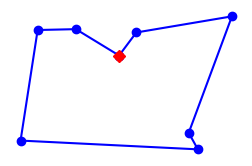

In [8]:
plot_tour(exhaustive_tsp(random_cities(8)))

The plot helps convince me that this is indeed the shortest tour.


I will define the function `run` to run a TSP algorithm on a set of cities, verify that the tour is valid, and optionally plot the tour. It returns a `Run` object, which packages up the resulting tour and the run time, and has a pretty representation.

In [9]:
def run(tsp: callable, cities: Cities, plot=True):
    """Run a TSP algorithm on a set of cities and plot the results if `plot` is true."""
    t0   = time.perf_counter()
    tour = tsp(cities)
    t1   = time.perf_counter()
    assert valid_tour(tour, cities)
    if plot:
        plot_tour(tour)
    return Run(tour, t1 - t0, tsp)

class Run:
    """The tour found by a run and the time it took to compute it."""
    def __init__(self, tour, seconds, tsp):
        self.tour = tour
        self.msec = 1000 * seconds
        self.name = tsp.__name__
        self.length = tour_length(tour)
    def __repr__(self): 
        return f"[{self.name}({len(self.tour)} cities) ⇒ {self.length:,.0f} length tour in {self.msec:,.0f} msecs]"

Here is `run` in action, this time on 9 cities, and then 10:

[exhaustive_tsp(9 cities) ⇒ 8,252 length tour in 219 msecs]

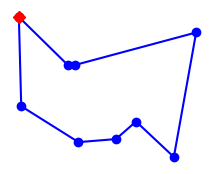

In [10]:
run(exhaustive_tsp, random_cities(9))

[exhaustive_tsp(10 cities) ⇒ 7,602 length tour in 2,278 msecs]

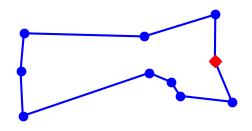

In [11]:
run(exhaustive_tsp, random_cities(10))

The algorithm is already starting to get slow; about 2.5 seconds for 10 cities. The exhaustive search algorithm considers all permutations of the *n* input cities, so the run time  is  *O*(*n*!) in  [Big *O* notation](https://en.wikipedia.org/wiki/Big_O_notation). 

(Note: we could get it down to (*n*-1)! by noticing that the permutations [A, B, C], [B, C, A], and [C, A, B] are all actually the same tour, so we only need to look at one of them. But *O*((*n*-1)!) is still untenable, so I won't bother making this improvement.)

# General Strategies for Algorithm Design

It takes Exhaustive Search about 2.5 seconds to solve an 10-city problem, so 11 cities would take 11 times as long, and just 16 cities would take over a week. 
There must be a better way ... 

To get inspired, here are some general  strategies for algorithm design: 

* **Brute Force Strategy**: The strategy used for `exhaustive_tsp`; as [Ken Thompson](https://en.wikipedia.org/wiki/Ken_Thompson) [says](https://www.brainyquote.com/quotes/ken_thompson_185574?src=t_brute_force), "*when in doubt, use brute force*."
* **Approximation Strategy**: If it is too hard to find an exact, optimal solution, consider an approximate, slightly suboptimal solution.
* **Greeedy Strategy**: To complete a multiple step problem, first do the step that appears to be best in the short run. Repeat. 
* **Local Search Strategy**: Create a solution, then check if small local edits improve it.
* **Divide and Conquer Strategy**: Split the problem into pieces, solve each piece, and combine the solutions.
* **Ensemble Strategy**: Let a set of algorithms each try the problem, and pick the best solution. 
* **Stand on the Shoulders of Giants Strategy**: Find out what other people have done, and copy them.

Let's apply these strategies to develop some TSP algorithms. We'll make a quick journey through the various algorithms, and then step back to test them on a series of benchmarks.


#  Nearest Neighbor Algorithm (nearest_tsp)

Here's a second TSP algorithm. It is inspired by the **approximation strategy** and the **greedy strategy**. It is approximate because it is not guaranteed to find the shortest path. It is greedy because at each step it makes the choice that looks best in the short run, even if that is not actually the best in the long run.

- **Nearest Neighbor TSP Algorithm:** *Create a partial tour that initially is just the start city. At each step extend the partial tour to the nearest unvisited neighbor of the last city in the partial tour, until there are no unvisited cities remaining.*



In [12]:
def nearest_tsp(cities: Cities, start:City=None) -> Tour:
    """Create a partial tour that initially is just the start city. 
    At each step extend the partial tour to the nearest unvisited neighbor 
    of the last city in the partial tour, while there are no unvisited cities remaining."""
    tour = [start or first(cities)]
    unvisited = set(cities) - set(tour)
    while unvisited:     
        nearest = min(unvisited, key=lambda C: distance(C, tour[-1]))
        tour.append(nearest)
        unvisited.remove(nearest)
    return tour

def first(items: Iterable) -> object: 
    """The first element of a collection or iterable."""
    return next(iter(items))

The nearest neighbor algorithm builds *n* links in the tour and at each step considers up to *n* - 1 possibile neighbors, so we say it is *O*(*n*<sup>2</sup>). That means it runs a lot faster than the exhaustive algorithm! In a second of run time, `exhaustive_tsp` couldn't even handle 10 cities, while `nearest_tsp` can easily handle 5,000:

[nearest_tsp(5000 cities) ⇒ 154,542 length tour in 793 msecs]

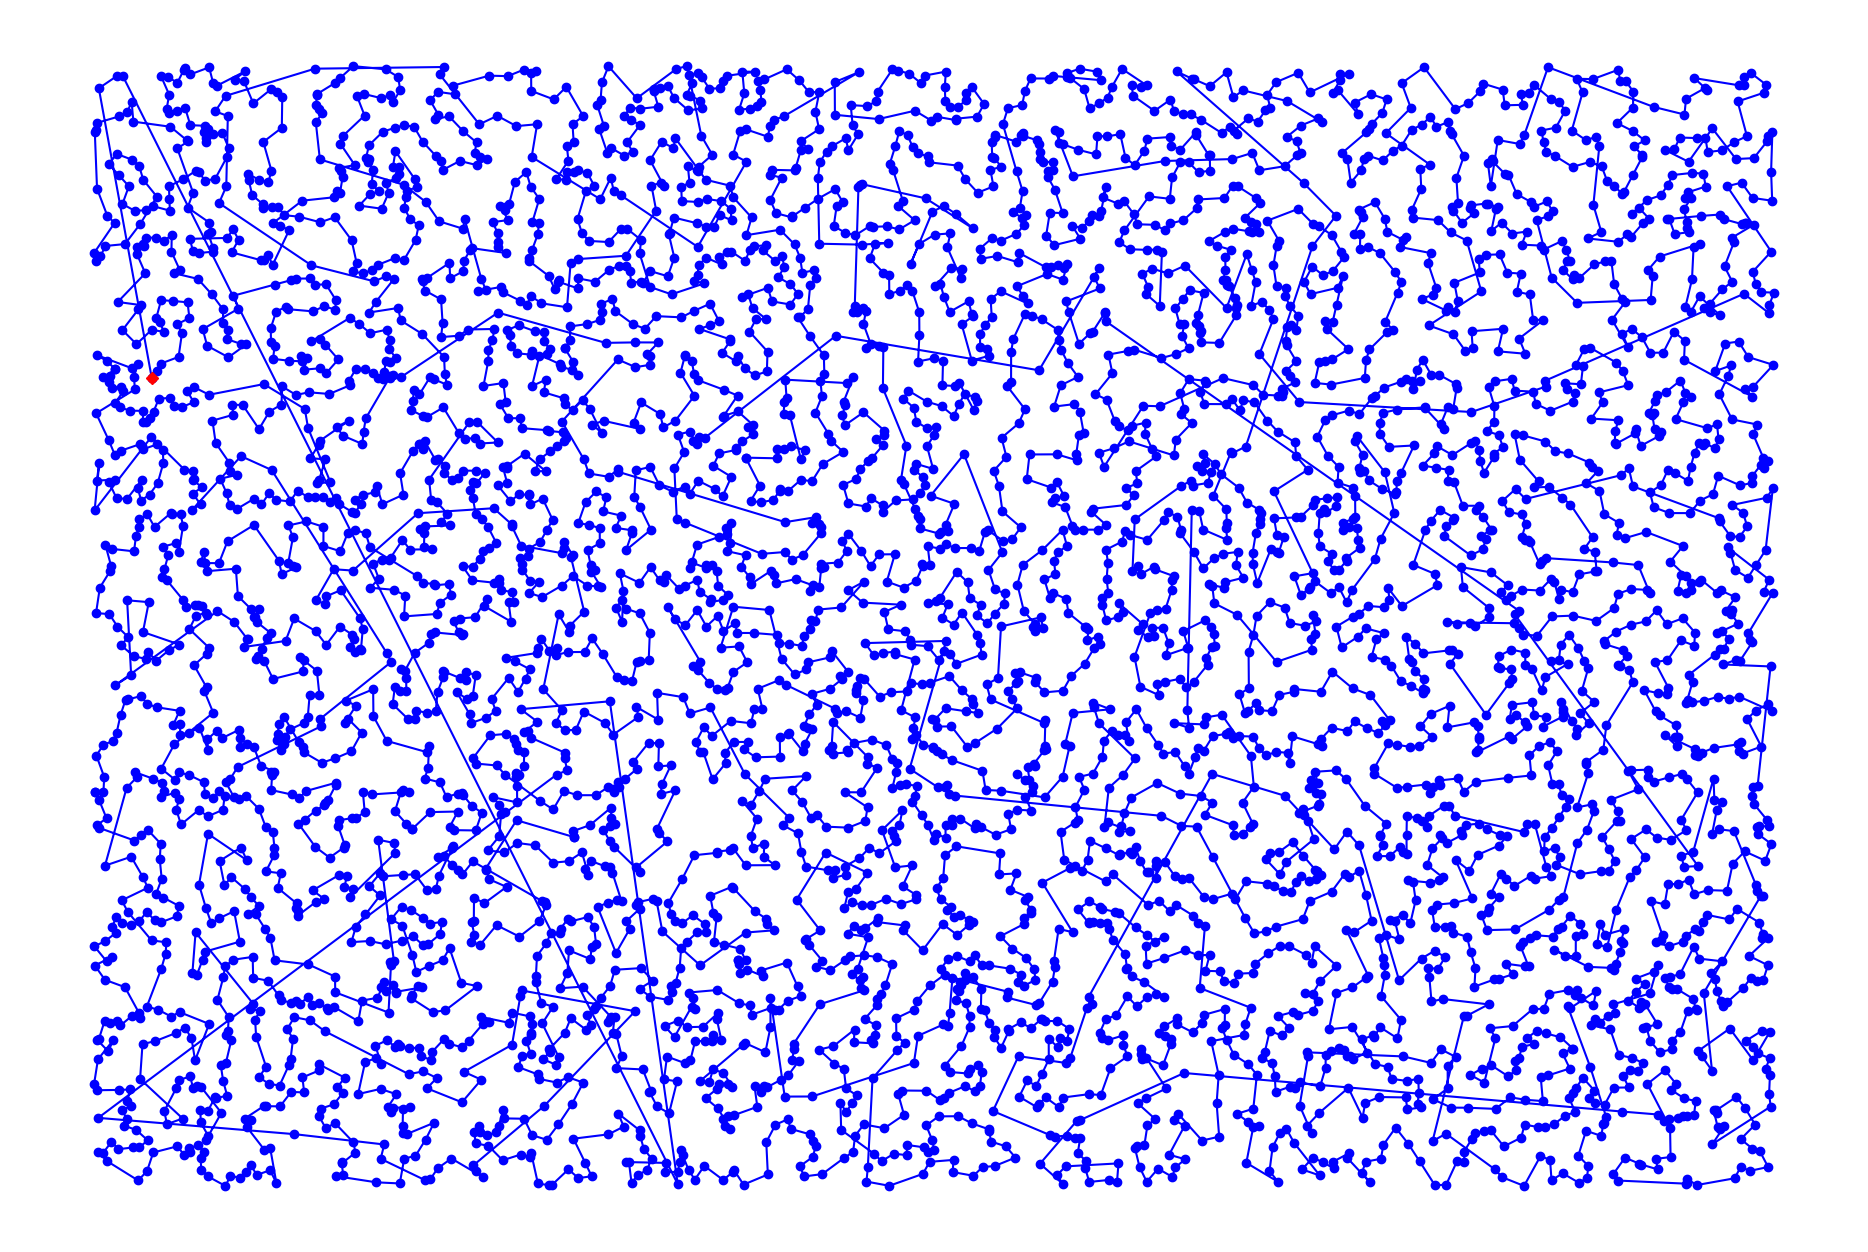

In [13]:
run(nearest_tsp, random_cities(5000))

# Real-World Cities

A tour of 5,000 random cities looks like a [Jackson Pollack](https://www.moma.org/artists/4675) painting.  I thought it would be fun to work on some *real* cities. I found a  [list](https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm) of over 1200 cities in the USA with latitude/longitude coordinates, in the following format:

In [14]:
! [ -e latlong.csv ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/refs/heads/main/data/latlong.csv
!head latlong.csv

85.85,33.58,Anniston,AL
85.44,32.67,Auburn,AL
86.75,33.57,Birmingham,AL
87.25,32.9,Centreville,AL
85.45,31.32,Dothan,AL
85.72,31.28,Fort Rucker,AL
86.09,33.97,Gadsden,AL
86.77,34.65,Huntsville,AL
86.37,32.38,Maxwell AFB,AL
88.25,30.68,Mobile,AL


I define the function `parse_cities` to extract cities from this format (by default skipping Alaska and Hawaii):

In [15]:
def parse_cities(rows: Iterable[tuple], skip=('AK', 'HI'), long_scale=-48, lat_scale=69) -> Cities:
    """Make a set of Cities from the CSV file of "long,lat,city,state", skipping the given states."""
    return Cities(City(int(long_scale * float(long)), int(lat_scale  * float(lat)))
                  for (long, lat, city, state) in rows
                  if state not in skip)

USA = parse_cities(csv.reader(open('latlong.csv')))

(You might be wondering about the `long_scale=-48, lat_scale=69` part. The issue is that computing distance from latitude and longitude on a globe requires [complicated trigonometry](http://en.wikipedia.org/wiki/Haversine_formula).  But we can get an approximation by assuming that latitude and longitude are on a flat rectangular grid. (This is a bad approximation if you're talking about links of 1,000 miles, but close enough for shorter links, as long as you're not too near the poles.)  I took the latitude of the center of the USA (Wichita, KS: latitude 37.65) and plugged it into a [Length Of A Degree Of Latitude
And Longitude Calculator](http://www.csgnetwork.com/degreelenllavcalc.html) to find that, in Wichita, one degree of latitude is 69 miles, and one degree of longitude is 48 miles.  I use -48 rather than +48 because the USA is west of the prime meridian.) 

Let's find a nearest neighbor tour on the USA map:

[nearest_tsp(1088 cities) ⇒ 53,364 length tour in 50 msecs]

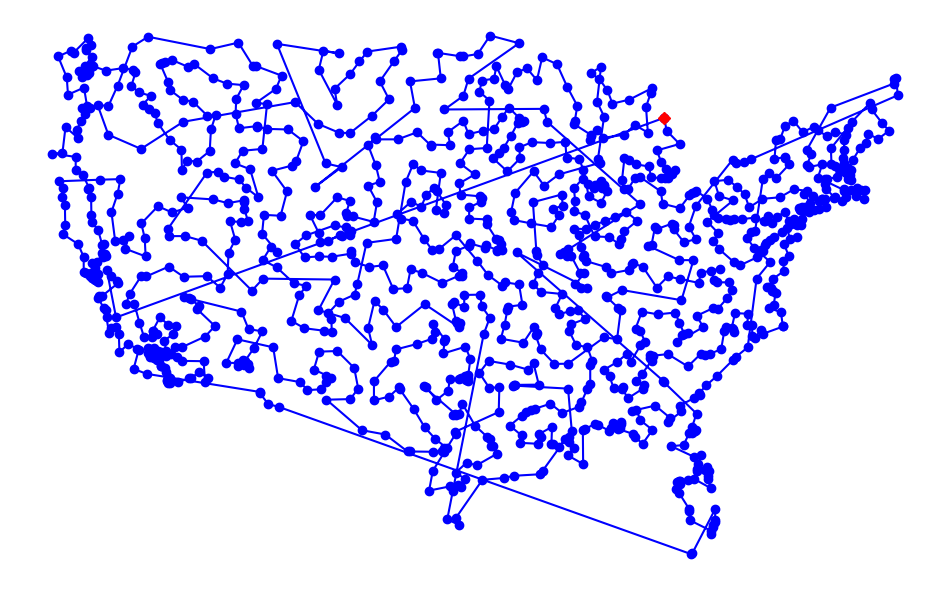

In [16]:
run(nearest_tsp, USA)

# Greedy TSP Algorithm (greedy_tsp)

The Nearest Neighbor Algorithm follows the **greedy strategy** in always choosing the neighbor that is nearest to the **previous city** in the tour. Another way to be greedy is to always choose the shortest possible link, **anywhere** in the map, not just from the previous city in the partial tour. It works like this: 

> **Greedy Algorithm:** *Maintain a set of **segments**; intially each city defines its own 1-city segment. Find the shortest possible link that connects two endpoints of two different segments, and join those segments with that link to form one bogger segmenr. Repeat until we form a single segment that tours all the cities.*

On each step of the algorithm, we want to *"find the shortest possible link that connects two endpoints."* That seems like an expensive operation to do on each step. So we will add some data structures  to speed up the computation:  

1. Pre-compute a list of links, sorted by shortest link first. A link is two-city segment: `[A, B]`.
2. Maintain a dict that maps **endpoints** to **segments**, e.g. `{A: [A, B, C], C: [A, B, C], D: [D]}` means that `A` and `C` are the endpoints of segment `[A, B, C]` and `D` is the only endpoint of a 1-city segment. 
3. Go through the links in shortest-links-first order and choose the next usable link. Given the dict listed above, suppose the next shortest link is:
    - `[B, D]`: Can't use it because `B` is not an endpoint; it is already attached to `A` and `C`  by shorter links. 
    - `[A, C]`: Can't use it; that would make `[A, B, C]` into a closed loop. 
    - `[C, D]`: Use it: join the two segments together, giving the updated endpoints dict: `{A: [A, B, C, D], D: [A, B, C, D]}`.
4. Stop when the newly created segment contains all the cities.

Here is the code:

In [17]:
def greedy_tsp(cities: Cities) -> Tour:
    """Go through links, shortest first. If a link can join segments, do it."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    for [A, B] in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            joined_segment = join_segments(endpoints, A, B)
            if len(joined_segment) == len(cities):
                return joined_segment
            
def shortest_links_first(cities: Cities) -> list[Link]:
    "Return all links between cities, sorted shortest first."
    links = itertools.combinations(cities, 2)
    return sorted(links, key=lambda link: distance(*link))
            
# TODO: join_segments

**Note:** The `endpoints` dict serves two purposes. First, the keys of the dict are cities that are endpoints of some segment, making it possible to ask "`A in endpoints`" to see if city `A` is an endpoint. Second, the value of `endpoints[A]` is the segment that `A` is an endpoint of, making it possible to ask "`endpoints[A] != endpoints[B]`" to make sure that the two cities are endpoints of different segments, not of the same segment (we don't want to join a segment to itself and form a loop).

For the `join_segments` function, I first make sure that `A` is the last element of one segment and `B` is the first element of the other, by reversing segments if necessary.  Then I add the B segment on to the end of the A segment. Finally, I update the `endpoints` dict by deleting `A` and `B` and then adding the two endpoints of the new segment: 

In [18]:
def join_segments(endpoints: dict, A: City, B: City) -> Segment:
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    # Make sure that Aseg ends in A and Bseg begins with B:
    if Aseg[0] is A and Bseg[-1] is B: 
        A, B = B, A        # Swap A and B
    if Aseg[-1] is not A:
        Aseg.reverse()     # Make sure Aseg ends in A
    if Bseg[0]  is not B:
        Bseg.reverse()     # Make sure Bseg begins with B
    Aseg += Bseg
    # Maintain endpoints dict:
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

Here is the greedy search in action:

[greedy_tsp(1088 cities) ⇒ 51,129 length tour in 146 msecs]

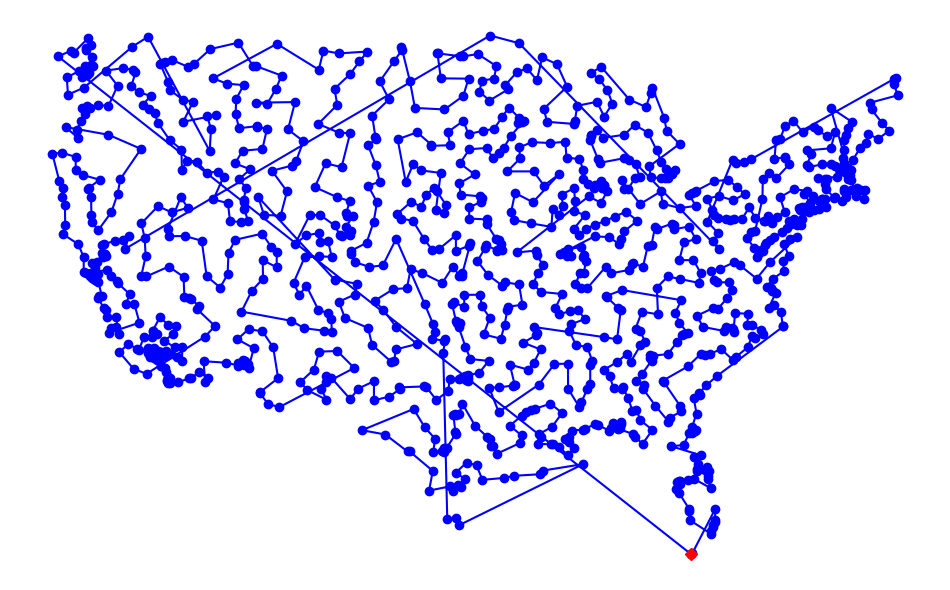

In [19]:
run(greedy_tsp, USA)

Both this tour and the one from `nearest_tsp` look good in some parts of the map, but there are a few very long links. Could we fix them? The next section shows one way to do that.

# Local Search Strategy (two_opt)

In the following diagram  (from [wikipedia](https://en.wikipedia.org/wiki/2-opt)) we see the top tour has two crossed links forming an ╳. In the bottom we see the same tour with the ╳ uncrossed. The bottom tour replaces two longer crossed links with two shorter links, thus improving the tour. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/2-opt_wiki.svg/360px-2-opt_wiki.svg.png)

We'd like to avoid results like the top tour. Could we modify a nearest-neighbor search to avoid making mistakes like the crossed links in the first place? That would be hard. When the tour gets to [a, b] it is not obvious that [a, b, e] is a mistake. it is only 3 links later when we make the [c, f] link that the problem becomes apparent.  So, rather than tackling the difficult task of **avoiding** mistakes, the **local search strategy** says to go ahead and make mistakes in creating the initial version of a tour, and then do the easier task of **fixing** the mistakes. 

Why is it easier to fix the mistakes? Because we can't easily answer the question "is it a mistake to extend [a, b] to [a, b, e]?" but we *can* easily and definitively answer the question "does replacing [b, e] and [c, f] with [b, c] and [e, f] make the tour shorter?"

When we are dealing with **Euclidean distance** (or any **[metric space](https://en.wikipedia.org/wiki/Metric_space)** for that matter), then by the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality) we can see that anytime there are two links that cross in an ╳ pattern, we should uncross the ╳. There can also be cases that don't involve an ╳ but still result in a shorter tour when you swap the links. You can think of this in two ways:
1) Break the links [b, e] and [c, f] and replace them with [b, c] and [e, f] (whenever this makes the tour shorter).
2) Reverse the segment [e, d, c] to become [c, d, e] (whenever this makes the tour shorter).

In the literature of TSP, this kind of improvement is called [**2-opt**](https://en.wikipedia.org/wiki/2-opt), because it involves deleting two links and replacing them with two optimized links. 

I'll define `two_opt(tour)` to consider various segments, and reverse a segment whenever that improves the tour. What segments should we consider? I don't know how to be clever about that, but I do know how to use **brute force**: try every subsegment. (I have an intuition (from experience with [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) that trying longer subsegments first would be better, so I'll write `subsegment_indexes` that way.) After I've tried all segments, if one of them did improve the tour I'll repeat the process until there are no improvements, then return the improved tour:

In [20]:
def two_opt(tour: Tour) -> Tour:
    """Perform 2-opt segment reversals to optimize tour. Repeat until no more improvement."""
    tour = list(tour) # Don't mutate the input tour
    while True:
        improved = False
        for (i, j) in subsegment_indexes(len(tour)):
            if reversal_is_improvement(tour, i, j):
                tour[i:j] = reversed(tour[i:j])
                improved = True
        if not improved:
            return tour
        
def reversal_is_improvement(tour: Tour, i: int, j: int) -> bool:
    """Would reversing the segment `tour[i:j]` make the tour shorter?"""
    # Given tour [...A,B...C,D...], would reversing B...C to C...B make the tour shorter?
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    return distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D)
        
@cache # All tours of length N have the same subsegment indexes, so cache them.
def subsegment_indexes(N: int) -> list[tuple[int, int]]:
    """Return (i, j) index pairs denoting tour[i:j] subsegments of a tour of length N."""
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in range(N - length)]

To be clear, `subsegment_indexes(5)` gives a list of the start and stop indexes of every segment in a 5-city tour that is from 2 to 4 cities long:

In [21]:
assert subsegment_indexes(5) == [(0, 4), (0, 3), (1, 4), (0, 2), (1, 3), (2, 4)]

Let's see how much 2-opt can improve tours:

In [22]:
def nearest_tsp_2opt(cities: Cities, start: City=None) -> Tour: 
    """Apply 2-opt to the result of nearest_tsp."""
    return two_opt(nearest_tsp(cities, start))

def greedy_tsp_2opt(cities) -> Tour: 
    """Run the greedy_tsp algorithm on cities and apply two_opt to the resulting tour."""
    return two_opt(greedy_tsp(cities))

[nearest_tsp_2opt(1088 cities) ⇒ 45,105 length tour in 676 msecs]

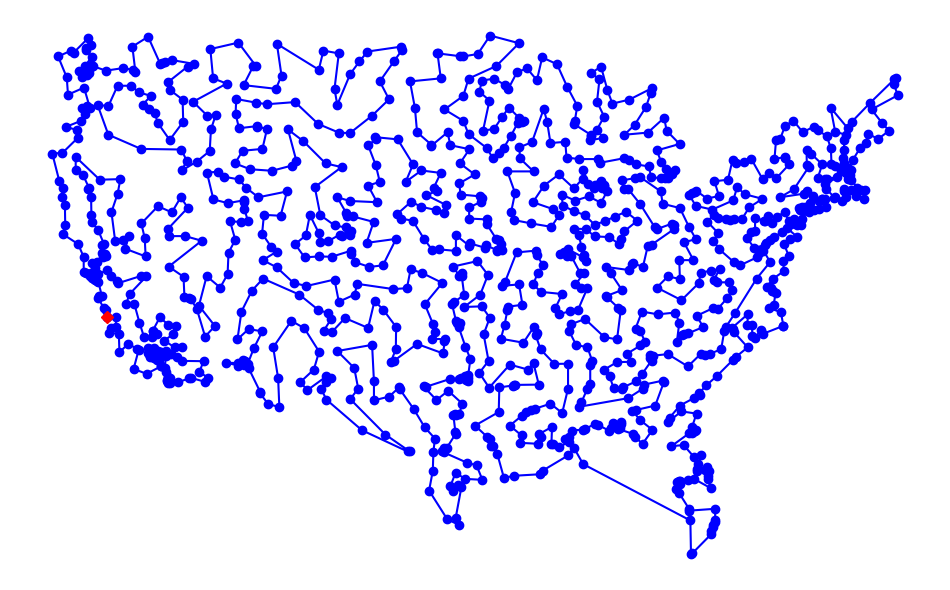

In [23]:
run(nearest_tsp_2opt, USA)

[greedy_tsp_2opt(1088 cities) ⇒ 44,417 length tour in 758 msecs]

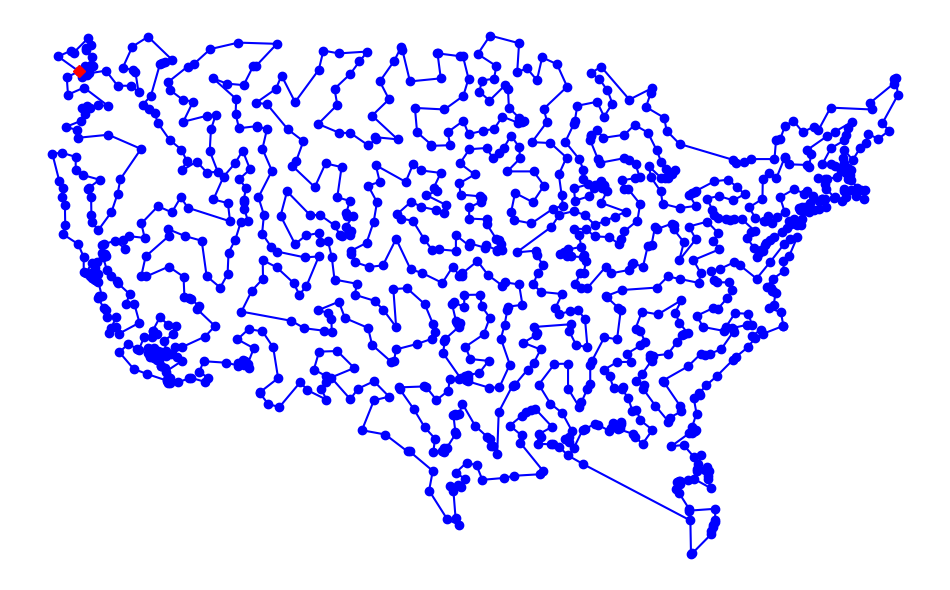

In [24]:
run(greedy_tsp_2opt, USA)

The very long links are gone, and there is an overall 15 to 20% improvement in tour length. But the run time is about 20 times longer.

# Divide and Conquer

The next general strategy to consider is **divide and conquer**.  For TSP it works like this:

1. Split the set of cities into two (or more) subsets. (Maybe the eastern and western halves.)
2. Find a tour for each subset of cities.
3. Join those tours into one.

When the number of cities is small, step 2 can be done directly by the exhaustive search algorithm.  But when it is large, step 2 is done with a recursive call. 

I implemented this approach and it worked, but the run time was slow and the resulting tours were longer than with other algorithms. I think the issue is that combining tours didn't necessarily lead to a good overall tour. You're free to experiment with this approach, but I decided to drop it.

# Ensemble Strategy (rep_nearest_tsp and ensemble_tsp)

So far we have seen several alternative TSP algorithms. But I don't know how to predict which algorithm will give the shortest tour on a specific set of cities.  That suggests we try  the **ensemble strategy**: run multiple TSP algorithms and choose the best resulting tour. 

Here's an idea for a simple kind of ensemble: 

- **Repeated Nearest Neighbors TSP algorithm**: repeat the `nearest_tsp` algorithm *k* times with *k* different starting cities, and take the shortest resulting tour.

Why is this a good idea? Because `nearest_tsp` gets different solutions depending on where we start. In the plot below we show the  best and worst tours that we get from starting `nearest_tsp` from each of 11 random cities. The best is a good tour, and the worst is a very bad tour.

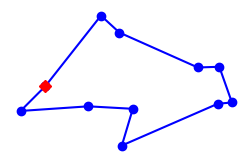

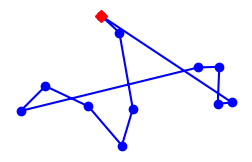

In [25]:
cities = random_cities(11)
tours = [nearest_tsp(cities, start=c) for c in cities]
plot_tour(min(tours, key=tour_length))
plot_tour(max(tours, key=tour_length))

Here is the Repeated Nearest Neighbors algorithm. I'll define three versions: one without 2-opt, one that applies 2-opt to the shortest of the *k* tours, and one that applies 2-opt to every candidate tour:

In [26]:
def rep_nearest_tsp(cities: Cities, k=50):
    """Repeat `nearest_tsp` with `k` different start cities; pick the shortest tour."""
    start_cities = random.sample(list(cities), k)
    return shortest(nearest_tsp(cities, start) for start in start_cities)

def rep_nearest_tsp_2opt(cities: Cities, k=10):
    """Repeat `nearest_tsp` with `k` different start cities; pick the shortest tour and apply 2-opt."""
    return two_opt(rep_nearest_tsp(cities, k))

def rep_2opt_nearest_tsp(cities: Cities, k=5):
    """Repeat `nearest_tsp` followed by 2-opt on `k` different start cities; pick the shortest tour"""
    start_cities = random.sample(list(cities), k)
    return shortest(two_opt(nearest_tsp(cities, start)) for start in start_cities)

Next I'll define another ensemble method,  `ensemble_tsp_2opt`, which runs a collection of algorithms  and takes the shortest resulting tour:

In [27]:
def ensemble_tsp_2opt(cities, tsps=(greedy_tsp_2opt, rep_2opt_nearest_tsp)): 
    "Apply an ensemble of TSP algorithms to cities and take the shortest resulting tour."
    return shortest(tsp(cities) for tsp in tsps)

[ensemble_tsp_2opt(1088 cities) ⇒ 44,417 length tour in 4,191 msecs]

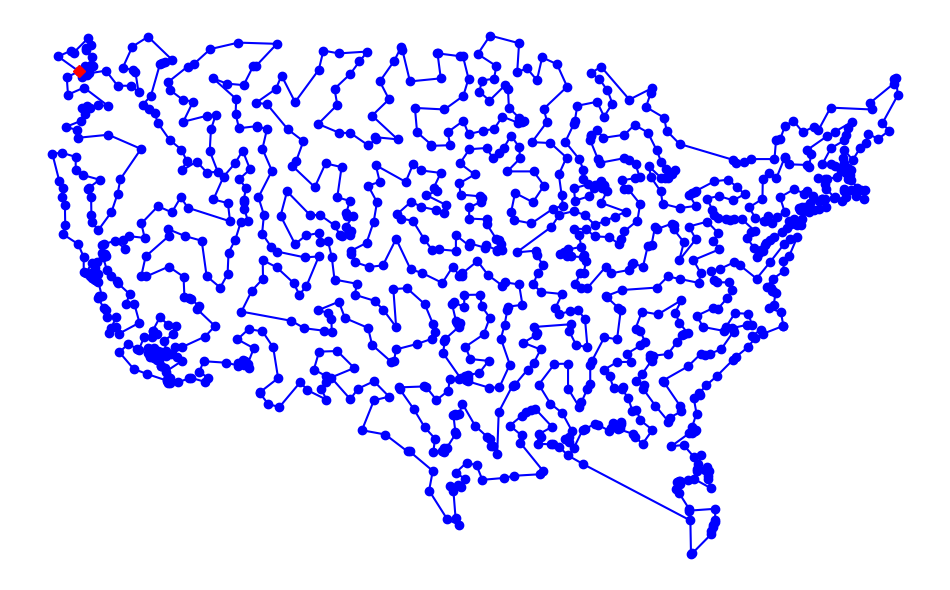

In [28]:
run(ensemble_tsp_2opt, USA)

# Shoulders of Giants: Minimum Spanning Tree Algorithm

I hope you feel that you could have come up with some ideas for solving the TSP, using the set of **strategies**. But even if you can't come up with something all on your own, you can follow the **Stand on the Shoulders of Giants Strategy**, also known as the **[Just Google it Strategy](http://bit.ly/XNGt2y)**, in which case you'll no doubt find a giant of a mathematician, [Joseph Kruskal](http://en.wikipedia.org/wiki/Joseph_Kruskal), who, in 1956, published [a paper](http://www.cmat.edu.uy/~marclan/TAG/Sellanes/Kruskal.pdf) that led to an algorithm that
most people would not have thought of on their own (I know I wouldn't have):

> **Minimum Spanning Tree Traversal Algorithm:** *Construct a Minimum Spanning Tree, then do a pre-order traversal.  That will give you a tour that is guaranteed to be no more than twice as long as the minimal tour.* 

What does all this jargon mean? It is part of *[graph theory](https://en.wikipedia.org/wiki/Graph_theory)*.  Here is a glossary of terms:

* A **graph** is a collection of vertexes and links.
* A **vertex** is a point (such as a city).
* A **link** is an edge between two vertexes. Links have lengths.
* A **directed graph** is a graph where the links have a direction.  We say that the link goes from the **parent** vertex to the **child** vertex.
* A **tree** is a directed graph in which one vertex called the **root** has no parent, and every other vertex has exactly one parent. 
* A **spanning tree** (of a set of vertexes) is a tree that contains all the vertexes.    
* A **minimum spanning tree** is a spanning tree with the smallest sum of link lengths.
* A **traversal** of a tree is a way of visiting all the vertexes in some order.
* A **pre-order traversal** means that you visit the root first, then do a pre-order traversal of each child in order.


We will implement a directed graph as a dict of `{parent: [child, ...]}`. Now our plan is:

1. Implement an algorithm to create a minimum spanning tree, `mst`.
2. Implement a tree traversal; that will give us our `mst_tsp` algorithm.
3. Understand the guarantee.

Let's see how to create a minimum spanning tree (or MST).  Kruskal has a very nice algorithm to find MSTs, but with what we have done so far, it will be a bit easier to implement [another Giant](https://en.wikipedia.org/wiki/Robert_C._Prim)'s algorithm:

> **[Prim's algorithm for creating a MST](http://en.wikipedia.org/wiki/Prim%27s_algorithm):** *List all the links and sort them, shortest first.  Initialize a tree to be a single root city (we'll arbitrarily choose the first city). Now repeat the following until the tree contains all the cities: find the shortest link that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.*

Here's the code. One tricky bit: In the first line inside the `while` loop, we assign `(A, B)` to be a link in which exactly one of `A` or `B` is in the tree, using the exclusive-or operator, `^`.  Then in the next line, we make sure that `A` is the one that is in the tree and B is not, by swapping if necessary.

In [29]:
Graph = dict

def mst(vertexes: Cities) -> Graph:
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form 
    {parent: [child...]}, spanning all vertexes."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    links = shortest_links_first(vertexes)
    while len(tree) < len(vertexes):
        [A, B] = first([A, B] for [A, B] in links if (A in tree) ^ (B in tree))
        if A not in tree: 
            A, B = B, A
        tree[A].append(B)
        tree[B] = []
    return tree

Let's see what a minimum spanning tree looks like. We can't use `plot_tour` so we'll need a new plotting function, and I'll use a different color to make it clear that these are trees, not tours:

In [30]:
def plot_graph(graph: Graph) -> None:
    "Given a graph of the form {parent: [child...]}, plot all links."
    links = ((parent, child) for parent in graph for child in graph[parent])
    for link in links:
        plot_segment(link, 'g.-')

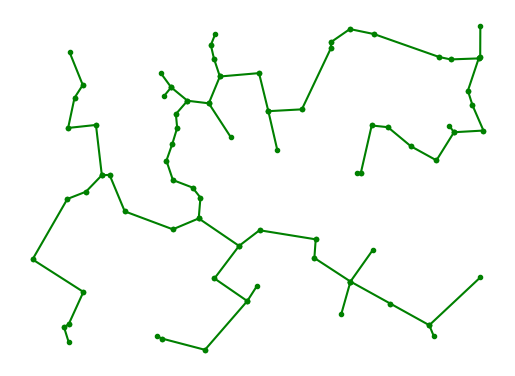

In [31]:
plot_graph(mst(random_cities(75)))

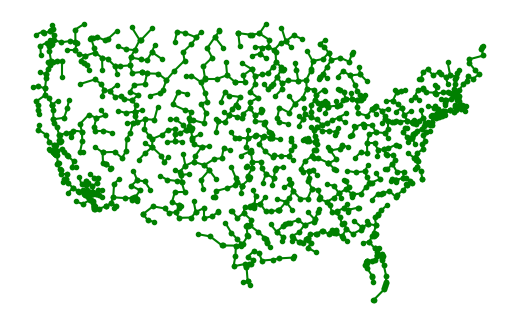

In [32]:
plot_graph(mst(USA))

Those certainly look like spanning trees.  But can we prove they are **minimum** spanning trees?  

1. The output is a **tree** because:
    - Every city is connected by a path from the root.
    - Every city only gets one parent (we only add a B that is not in the tree), so there can be no loops. 
2. The output is a **spanning tree** because it contains all the cities.
3. The output is a **minimum spanning tree** because each city was added with the shortest possible link.  Suppose this algorithm produces the tree T. For another spanning tree to be shorter, it would have to contain at least one city B whose link from its parent was shorter than the corresponding link in T. But that is not possible, because the algorithm always chooses the shortest possible link to B.


Given a minimum spanning tree, we can generate a tour by doing a pre-order traversal, which means the tour starts at the root, then visits all the cities in the pre-order traversal of the first child of the root, followed by the pre-order traversals of any other children.

In [33]:
def mst_tsp(cities: Cities) -> Tour:
    """Create a minimum spanning tree and walk it in pre-order to produce a tour."""
    return Tour(preorder_traversal(mst(cities), first(cities)))

def preorder_traversal(tree: Graph, root: City) -> Iterable[City]:
    """Traverse tree in pre-order, starting at root of tree."""
    yield root
    for child in tree.get(root, ()):
        yield from preorder_traversal(tree, child)

You can think of this as starting at the root of the tree and going around the outside of the tree, as if you were walking with your hand always touching a link, but skipping cities you have already been to.

Let's see what `mst_tsp` can do on the USA map:

[mst_tsp(1088 cities) ⇒ 58,201 length tour in 227 msecs]

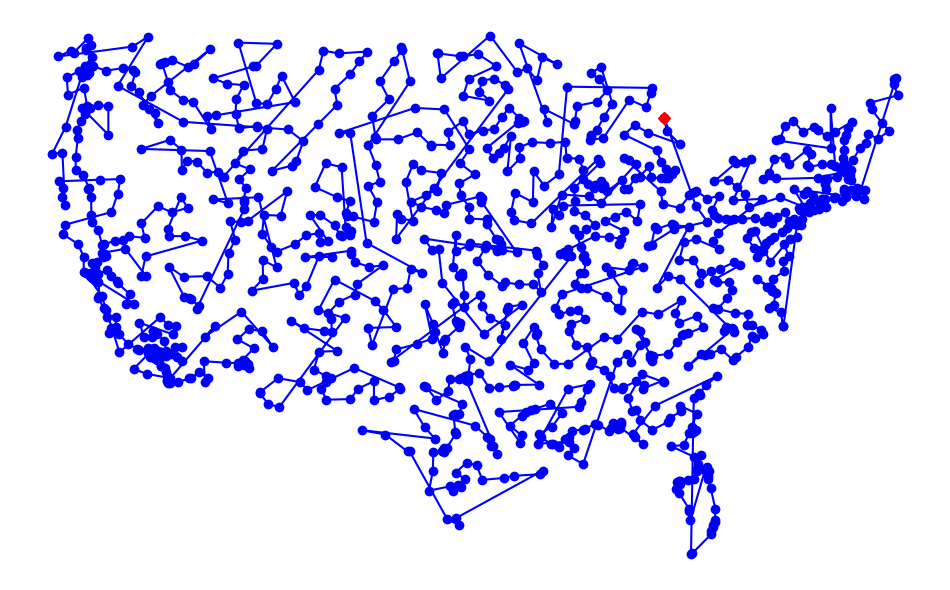

In [34]:
run(mst_tsp, USA)

Why would anyone want to use the minimum spanning tree algorithm, when the nearest neighbor algorithm is simpler to describe, simpler to implement, runs faster, and (at least on this one USA map) produces a shorter tour? 


The "giant" thing about the minimum spanning tree algorithm is that it comes with a *guarantee*, which none of the other algorithms offer (except for `exhaustive_tsp`, which is guaranteed to find the optimal algorithm, if it has enough time to complete). The algorithm  guarantees that the tour length will be no worse than twice as long as the optimal tour.  (And, with a bit more [complication](https://en.wikipedia.org/wiki/Christofides_algorithm), you can modify it to give a guarantee of 1.5 times longer.)  The guarantee works like this:

1. The minimum spanning tree, by definition, connects all the cities with the shortest possible total link length.
2. So if you could follow each link in the spanning tree just once, and that formed a legal tour, then that would be guaranteed to be
a minimal tour.  
3. But you can't do that in general; in general there will be places where you skip to the next city without following the spanning tree.  Any such skip, however, is a straight line, and thus will be less than you would take if you went to the next city by following along the spanning tree.
4. If you did follow along the spanning tree, you would follow some links twice, and some links once.  Hence the total length of the tour would be at most twice the spanning tree, and thus at most twice the minimal tour.

A guarantee is great from a theoretical point of view, but in practice the greedy or nearest neighbor algorithms almost always do better than the minimum spanning tree,  on the maps that we actually see. 

We'll define the 2-opt version of the minimum spanning tree algorithm, for use in the benchmarking section:

In [35]:
def mst_tsp_2opt(cities) -> Tour: 
    """Create a minimum spanning tree and walk it in pre-order to produce a tour; then apply 2-opt."""
    return two_opt(mst_tsp(cities))

# Shoulders of Giants: Held-Karp Algorithm (held_karp_tsp)

| ![](http://imgs.xkcd.com/comics/travelling_salesman_problem.png) |
|----|
| [xkcd 399](http://xkcd.com/399/) |


Another algorithm that shows up with a literature search is the [Held-Karp Dynamic Programming Algorithm](http://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm), named after giants [Michael Held](http://www.computerhistory.org/collections/catalog/102650390) and [Richard Karp](http://en.wikipedia.org/wiki/Richard_M._Karp). It is an algorithm for finding optimal tours, not approximate ones, so it is not appropriate for large *n*.  But even in its simplest form, without any complex programming tricks, it can go quite a bit further than `exhaustive_tsp`.  That is because `exhaustive_tsp` is O(*n*!), while the Held-Karp algorithm is only O(*n*<sup>2</sup> 2<sup>*n*</sup>).  How did Held and Karp achieve this speedup?  They noticed that `exhaustive_tsp` wastes a lot of time with permutations that can't possibly be optimal tours.  Here's the key idea:

- **Key idea**: *Given a start city A, an end city C, and a set of middle cities Bs, then out of all the possible segments that start in A, end in C, and go through all and only the cities in Bs, only the shortest of those segments could ever be part of an optimal tour.*

Of course, we don't know that the optimal tour goes through exactly those Bs cities before hitting C.  But if it does, then we need only consider the permutation of Bs that leads to the shortest segment.  Why is that such a big deal? Suppose we are considering segments of the form:

     [A, {B1, ... B10}, C, {D1, ... D10}, E]
     
That is, segments that start with A, then have have 10 B<sub>i</sub> cities in some order, then C, then 10 D<sub>j</sub> cities in some order, then E. With the Exhaustive Search algorithm, we have to consider all orderings of B<sub>i</sub> and all orderings of D<sub>j</sub>, so overall there would be (10!)<sup>2</sup> &approx; 13 trillion orderings of this form. But with Held-Karp, we consider the B<sub>i</sub> and D<sub>j</sub> separately, and chose the best segment from each, giving us only 2 &times; 10! &approx; 7 million orderings to consider. (Actually it is even better than that, because we use Held-Karp recursively to split the B<sub>i</sub> and D<sub>j</sub> into pieces.) 

So far we have only been talking about segments.  We know that the TSP is defined for tours, not segments. So even if we find the shortest possible segment, it might not be the shortest possible tour.  But here's something we do know: a tour has to end somewhere.  So we have:

- **Held-Karp algorithm**: *Find the shortest segment from the start city, `A`, to each possible end city, `C`, using the key idea above.   Out of those segments, choose the one that is the shortest tour.*

In [36]:
def held_karp_tsp(cities) -> Tour:
    """The Held-Karp shortest tour of this set of cities.
    For each end city C, find the shortest segment from A (the start) to C.
    Out of all these shortest segments, pick the one that is the shortest tour."""
    A = first(cities)
    shortest_segment.cache_clear() # Clear cache for a new problem
    return shortest(shortest_segment(A, cities - {A, C}, C)
                    for C in cities - {A})

# TO DO: shortest_segment(A, Bs, C)

Now for `shortest_segment(A, Bs, C)`, the shortest segment that starts in city `A`, ends in `C`, and visits some permutation of `Bs` cities in the middle.  If there are no `Bs` cities, then of course the shortest segment is to go directly from `A` to `C`.  If there are `Bs` cities, then one of them has to be the last `B` city visited (just before visiting `C`). So for each `B`, find the shortest segment that first goes from `A`, through all the other `Bs` cities, then to `B`, and finally to `C`.  Out of all these candidate segments, return the one with the minimum segment length.

**Note:** the decorator `@cache` makes this a **dynamic programming** algorithm, which is a fancy name meaning that we cache the results of sub-computations because we will re-use them multiple times. In the function `held_karp_tsp` we clear the cache at the start of each new problem.

In [37]:
@cache
def shortest_segment(A: City, Bs: set[City], C: City) -> Segment:
    """The shortest segment starting at A, going through all Bs, and ending at C.
    One of the Bs has to be last, so try each one in turn and take the shortest segment."""
    if not Bs:
        return [A, C]
    else:
        return min((shortest_segment(A, Bs - {B}, B) + [C] for B in Bs),
                   key=segment_length)

def segment_length(segment: Segment) -> float:
    """The total of distances between each pair of consecutive cities in the segment."""
    # Same as tour_length, but without the distance from last to first
    return tour_length(segment) - distance(segment[0], segment[-1])

That's all there is to it.  Let's try a run:

[held_karp_tsp(10 cities) ⇒ 7,602 length tour in 10 msecs]

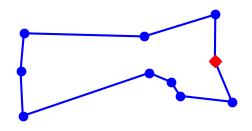

In [38]:
run(held_karp_tsp, random_cities(10))

[exhaustive_tsp(10 cities) ⇒ 7,602 length tour in 2,371 msecs]

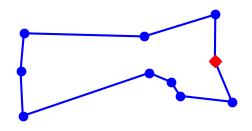

In [39]:
run(exhaustive_tsp, random_cities(10))

We see that `held_karp_tsp` gets the same result as `exhaustive_tsp` but runs a lot faster.  We can extend into uncharted territory  beyond the reach of  `exhaustive_tsp`:

[held_karp_tsp(15 cities) ⇒ 8,063 length tour in 892 msecs]

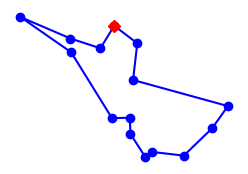

In [40]:
run(held_karp_tsp, random_cities(15))

Not bad! To see how much time we save using `held_karp_tsp` over `exhaustive_tsp`, we can extrapolate from the timings we've done, using the fact that Held-Karp is *O*(*n*<sup>2</sup> 2<sup>*n*</sup>) while Exhaustive Search is *O*(*n*!), to get this table:


|*n*|Exhaustive Search|Held Karp|
|---|---|---|
|10| 0.4 secs                | 0.01 secs |
|15|&approx; 2 days |0.9 secs|
|25|&approx; <a href="https://www.google.com/search?q=0.4+seconds*25!+%2F+10!+in+years">50 billion years</a>|&approx; 30 minutes|



So in under an hour, `held_karp_tsp` could give us an answer on a 25-city problem that saves 50 billion years of computing time compared to `exhaustive_tsp`.  The original Held-Karp algorithm had refinements that allowed it to handle 50-city sets in hours, not centuries, and could do so even with 1970s-era computing power! See **Branch and Cut** below and look into representing sets as bit masks.


# Benchmarking

Here are all the TSP algorithms we developed, grouped by type, and commented with their strategy:

In [41]:
simple_tsps   = (nearest_tsp, greedy_tsp, mst_tsp)                # Greedy strategy (and Giant Shoulders)
two_op_tsps   = (nearest_tsp_2opt, greedy_tsp_2opt, mst_tsp_2opt) # Local search strategy
ensemble_tsps = (ensemble_tsp_2opt, rep_nearest_tsp, rep_nearest_tsp_2opt, rep_2opt_nearest_tsp) # Ensemble strategy
exact_tsps    = (exhaustive_tsp, held_karp_tsp)                   # Brute Force, Giant Shoulders

inexact_tsps  = simple_tsps + two_op_tsps + ensemble_tsps         # Not guaranteed to find shortest tour

Which algorithm is best? I can't tell by trying them on only one or two problems. What I need to do is **benchmark** each algorithm on a standard **test suite** of problems, and use  **statistical tests** to compare the algorithms. If the test suite is large enough, the results will have statistical significance. If the test suite is representative of the problems we want to solve, the results will have relevance. I'll build the following tools:
- `test_suite`: A function to build a `TestSuite`: a tuple of multiple random sets of cities.
- `Runs`: A data structure that summarizes the results of *n* runs of q TSP algorithm on a test suite.
- `benchmarks`: A function to run multiple TSP algorithms on a test suite.
- `benchmark`: A function to run one 

First a way to create a test suite:

In [42]:
TestSuite = tuple[Cities]

@cache
def test_suite(num_sets: int, num_cities: int) -> TestSuite:
    "Return `num_sets` different sets of `num_cities` random cities."
    return tuple(random_cities(num_cities, seed=i) for i in range(num_sets))

Now a class, `Runs`, to hold the summarized results of multiple runs of a TSP algorithm on each set of cities in a test suite: 

In [43]:
class Runs:
    """The tour lengths and run times of a TSP algorithm on a TestSuite, 
    with a representation showing the mean tour length and run time,
    along with ± the standard deviation of those statistics."""
    def __init__(self, runs, shortest=None):
        runs         = list(runs)
        self.name    = runs[0].name
        self.ncities = len(runs[0].tour)
        self.nruns   = len(runs)
        self.lengths = [run.length for run in runs]
        self.shortest= shortest or mean(self.lengths)
        self.msecs   = [run.msec for run in runs]
    def __repr__(self):
        length = f"{mean(self.lengths):6,.0f} (± {stdev(self.lengths):5,.0f}) mean length"
        times  = f"{mean(self.msecs):3,.0f} (± {stdev(self.msecs):4.1f}) msecs"
        percent = f"({mean(self.lengths) / self.shortest:.2%})"
        return f"({self.name:>24}[{self.nruns} × {self.ncities} cities] ⇒ {length} {percent} in {times})"

Next, the function `benchmarks` takes a tuple of TSP algorithms, and runs each one on the test suite, producing a `Runs` object summarizing the results. It then finds the algorithm that proiduced the shortest mean tour length, and annotates each `Runs` object with that value, so that each `Runs` object can report what percentage they are above the shortest known value. The `Runs` are returned in sorted order by run length.

In [44]:
@cache
def benchmark(tsp: Callable, suite: TestSuite) -> Runs:
    """Run `tsp` on all the sets of cities in `suite` and return a `Runs` object."""
    return Runs(run(tsp, cities, plot=False) for cities in suite)
    
def benchmarks(tsps: tuple[Callable], suite: TestSuite) -> list[Runs]:
    """Benchmark TSP algorithm(s) on test suite(s); return a list of Runs objects."""
    results = [benchmark(tsp, suite) for tsp in tsps]
    shortest = min(mean(runs.lengths) for runs in results)
    for runs in results:
        runs.shortest = shortest
    return sorted(results, key=lambda run: mean(run.lengths))

We'll start by comparing the 3 **simple** TSP algorithms on test suites with different numbers of cities:

In [45]:
benchmarks(simple_tsps, test_suite(50, 250)) 

[(              greedy_tsp[50 × 250 cities] ⇒ 34,306 (± 1,208) mean length (100.00%) in   6 (±  0.3) msecs),
 (             nearest_tsp[50 × 250 cities] ⇒ 36,513 (± 1,559) mean length (106.43%) in   2 (±  0.0) msecs),
 (                 mst_tsp[50 × 250 cities] ⇒ 39,372 (± 1,216) mean length (114.77%) in   9 (±  9.1) msecs)]

In [46]:
benchmarks(simple_tsps, test_suite(25, 500)) 

[(              greedy_tsp[25 × 500 cities] ⇒ 47,751 (± 1,375) mean length (100.00%) in  27 (±  1.0) msecs),
 (             nearest_tsp[25 × 500 cities] ⇒ 50,844 (± 1,414) mean length (106.48%) in   8 (±  0.1) msecs),
 (                 mst_tsp[25 × 500 cities] ⇒ 55,283 (± 1,364) mean length (115.77%) in  35 (±  0.7) msecs)]

In [47]:
benchmarks(simple_tsps, test_suite(12, 1000)) 

[(              greedy_tsp[12 × 1000 cities] ⇒ 66,179 (± 1,457) mean length (100.00%) in 124 (±  3.5) msecs),
 (             nearest_tsp[12 × 1000 cities] ⇒ 70,877 (± 1,417) mean length (107.10%) in  31 (±  0.3) msecs),
 (                 mst_tsp[12 × 1000 cities] ⇒ 77,363 (± 1,365) mean length (116.90%) in 158 (±  3.2) msecs)]

We see that `greedy_tsp` consistently yields the shortest tours, but `nearest_tsp` is only 6% or 7% worse, and runs 3 or 4 times faster. The  minimum spanning tree algorithm (`mst_tsp`) is consistently worst in both tour length and run time. The one thing it has going for it is the theoretical guarantee of bounded optimality, but in practice that guarantee does not seem worth it.  

Now let's look at all the **inexact** algorithms:

In [48]:
%time benchmarks(inexact_tsps, test_suite(50, 250))

CPU times: user 24.6 s, sys: 28.1 ms, total: 24.6 s
Wall time: 24.6 s


[(       ensemble_tsp_2opt[50 × 250 cities] ⇒ 30,573 (±   599) mean length (100.00%) in 151 (± 16.3) msecs),
 (         greedy_tsp_2opt[50 × 250 cities] ⇒ 30,765 (±   614) mean length (100.63%) in  26 (±  4.5) msecs),
 (    rep_2opt_nearest_tsp[50 × 250 cities] ⇒ 30,859 (±   676) mean length (100.93%) in 123 (± 11.1) msecs),
 (    rep_nearest_tsp_2opt[50 × 250 cities] ⇒ 31,066 (±   689) mean length (101.61%) in  41 (±  5.2) msecs),
 (        nearest_tsp_2opt[50 × 250 cities] ⇒ 31,289 (±   651) mean length (102.34%) in  24 (±  4.3) msecs),
 (            mst_tsp_2opt[50 × 250 cities] ⇒ 31,360 (±   725) mean length (102.57%) in  31 (±  4.7) msecs),
 (              greedy_tsp[50 × 250 cities] ⇒ 34,306 (± 1,208) mean length (112.21%) in   6 (±  0.3) msecs),
 (         rep_nearest_tsp[50 × 250 cities] ⇒ 34,439 (± 1,053) mean length (112.64%) in  96 (±  1.5) msecs),
 (             nearest_tsp[50 × 250 cities] ⇒ 36,513 (± 1,559) mean length (119.43%) in   2 (±  0.0) msecs),
 (                 

In [49]:
%time benchmarks(inexact_tsps, test_suite(25, 500))

CPU times: user 58.1 s, sys: 103 ms, total: 58.2 s
Wall time: 58.2 s


[(       ensemble_tsp_2opt[25 × 500 cities] ⇒ 42,618 (±   677) mean length (100.00%) in 745 (± 63.7) msecs),
 (         greedy_tsp_2opt[25 × 500 cities] ⇒ 42,715 (±   750) mean length (100.23%) in 141 (± 29.8) msecs),
 (    rep_2opt_nearest_tsp[25 × 500 cities] ⇒ 43,102 (±   686) mean length (101.14%) in 595 (± 57.4) msecs),
 (    rep_nearest_tsp_2opt[25 × 500 cities] ⇒ 43,436 (±   629) mean length (101.92%) in 189 (± 20.8) msecs),
 (        nearest_tsp_2opt[25 × 500 cities] ⇒ 43,614 (±   614) mean length (102.34%) in 126 (± 26.1) msecs),
 (            mst_tsp_2opt[25 × 500 cities] ⇒ 44,077 (±   798) mean length (103.43%) in 153 (± 24.5) msecs),
 (              greedy_tsp[25 × 500 cities] ⇒ 47,751 (± 1,375) mean length (112.05%) in  27 (±  1.0) msecs),
 (         rep_nearest_tsp[25 × 500 cities] ⇒ 48,598 (± 1,236) mean length (114.03%) in 379 (±  5.8) msecs),
 (             nearest_tsp[25 × 500 cities] ⇒ 50,844 (± 1,414) mean length (119.30%) in   8 (±  0.1) msecs),
 (                 

By definition the ensemble algorithm produces the shortest tours, but the `greedy_tsp_2opt` is five times faster and produces tours that are within 1% in length. 

It is no surprise that 2-opt results have shorter tours (by about 10% across the board). Perhaps a surprise: they have lower variance. Probably because they have an ability to eliminate really bad links.

Next I compare the two **exact** algorithms, Exhaustive Search and Held-Karp, for their run times (knowing that they will each give exactly the same tour lengths):

In [50]:
benchmarks(exact_tsps, test_suite(30, 10))

[(          exhaustive_tsp[30 × 10 cities] ⇒  6,888 (±   843) mean length (100.00%) in 2,356 (± 34.6) msecs),
 (           held_karp_tsp[30 × 10 cities] ⇒  6,888 (±   843) mean length (100.00%) in   8 (±  1.9) msecs)]

We see Held-Karp is much faster, even on small 10-city sets; the timing difference will only increase for problems with more cities.

Now let's  compare Held-Karp to the ensemble algorithm:

In [51]:
benchmarks((held_karp_tsp, ensemble_tsp_2opt), test_suite(45, 10))

[(           held_karp_tsp[45 × 10 cities] ⇒  6,934 (±   882) mean length (100.00%) in   8 (±  0.2) msecs),
 (       ensemble_tsp_2opt[45 × 10 cities] ⇒  6,936 (±   881) mean length (100.02%) in   0 (±  0.0) msecs)]

In [52]:
benchmarks((held_karp_tsp, ensemble_tsp_2opt), test_suite(33, 12))

[(           held_karp_tsp[33 × 12 cities] ⇒  7,662 (±   715) mean length (100.00%) in  58 (±  9.1) msecs),
 (       ensemble_tsp_2opt[33 × 12 cities] ⇒  7,663 (±   714) mean length (100.02%) in   0 (±  0.0) msecs)]

In [53]:
benchmarks((held_karp_tsp, ensemble_tsp_2opt), test_suite(16, 14))

[(           held_karp_tsp[16 × 14 cities] ⇒  7,804 (± 1,008) mean length (100.00%) in 363 (± 19.3) msecs),
 (       ensemble_tsp_2opt[16 × 14 cities] ⇒  7,815 (± 1,010) mean length (100.14%) in   0 (±  0.0) msecs)]

In [54]:
benchmarks((held_karp_tsp, ensemble_tsp_2opt), test_suite(6, 16))

[(           held_karp_tsp[6 × 16 cities] ⇒  8,396 (± 1,060) mean length (100.00%) in 2,166 (± 52.7) msecs),
 (       ensemble_tsp_2opt[6 × 16 cities] ⇒  8,409 (± 1,067) mean length (100.16%) in   0 (±  0.0) msecs)]

This says that while `ensemble_tsp` does not guarantee an optimal tour, in practice on small random city sets it comes within about 0.1% most of the time, and runs much faster. How often does it find the optimal tour?

In [55]:
suite = test_suite(45, 10) + test_suite(33, 12) + test_suite(16, 14) + test_suite(6, 16)

mean(tour_length(ensemble_tsp_2opt(tour)) == tour_length(held_karp_tsp(tour)) 
     for tour in suite)

0.89

This says that on this test suite, `ensemble_tsp_2opt` finds the optimal tour 89% of the time.




# Further Explorations


That's all I'm going to write for now.  But there are still plenty of open questions for you to explore:

* **Branch and Cut**: this is a technique to cut off a search early, when a partial solution is obviously not optimal.  We saw how Held-Karp cuts off some permutations of cities when another permutation is better.  A refinement on that is to keep track of, say, the best total length of the segment going through all the Bs cities.  Then, any time you have a partial segment through some of the Bs cities that exceeds the best total, we can stop right there, before even finishing all the Bs.  With this technique, you can find optimal tours for around 50 cities.
* **Linear programming**: Look up the topic "linear programming" and see how it applies to TSP.
* **Heuristic Algorithms**: There are many approaches for using heurisitic estimates to find good (but not optimal) tours.  For example, *ant colony optimization algorithms* make random choices of which link to follow, and then the links that occur in the best tours get reinforced with some virtual pheromones, and other ants tend to follow those pheromones. *Simulated annealing* takes its inspiration from metallurgy, and *genetic algorithms* take their inspiration from evolution.
* The **[Lin-Kernighan heuristic](http://akira.ruc.dk/~keld/research/LKH/LKH-1.3/DOC/LKH_REPORT.pdf)** is a generalization of `two_opt` that can split the tour into more than two pieces, and considers all ways to put it back together. With such tricks, approximate algorithms  can handle hundreds of thousands of cities and come within 0.01% of the shortest possible tour. There is also a **3-opt** operator.
* The **[Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm)** gives a guarantee of 1.5 times the optimal tour length (improving on the minimum-spanning-tree guarantee of 2 times).
* Can you explain why `mst_tsp` produces a guaranteed result, while `greedy_tsp` does not, even though the two algorithms have similar structure in the way they iterate over `shortest_links_first`?
* The code in this notebook was designed for clarity, not efficiency.  Can you make the code faster? As one example, you could use a bit mask to represent a set of cities in Held-Karp; that should make a big difference.
* **[William Cook](https://www.math.uwaterloo.ca/~bico/)** has a comprehensive 
[web page](http://www.math.uwaterloo.ca/tsp/) on the TSP, as well as a great 
[book](https://press.princeton.edu/titles/9531.html) and a
[draft chapter](http://www.math.uwaterloo.ca/~bico/papers/comp_chapter1.pdf) on Discrete Optimization featuring TSP. Like my notebook here, Cook's chapter goes through a variety of algorithms for TSP, describing each one in prose and code. His coding style is different because he uses C (in an imperative style) while I used Python (in a mostly functional style).  His code is much more efficient (but if it is 100 times faster, that might only mean two more cities on `exhaustive_tsp`). Cook  chooses a different set of algorithms to explore, with more emphasis on optimizing algorithms that find guaranteed shortest tours. I find his explanations and code
are both beautiful and concise, and I think it is very interesting that
there can be two quite different approaches, which (in my opinion) both turn out very well.
* If you are heavily into math, there's a [taxonomy](http://cstheory.stackexchange.com/questions/9241/approximation-algorithms-for-metric-tsp) of solutions.
* What else are you interested in?